In [ ]:
###### DON'T USE IT, CRASHES AFTER RUNNING FOR MORE THAN AN HOUR

# from datasets import load_dataset

# # Login using e.g. `huggingface-cli login` to access this dataset
# ds = load_dataset("AisotTechnologies/aisot_btc_lob_trades")

In [ ]:
###### USE THIS METHOD INSTEAD

# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="AisotTechnologies/aisot_btc_lob_trades", allow_patterns="*.zip", local_dir='data/', repo_type='dataset')

Fetching 232 files: 100%|██████████| 232/232 [00:46<00:00,  4.97it/s]


'C:\\Users\\aliak\\my_space\\ETH\\ML Complex Systems\\MLFCS\\data'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *
import os

In [2]:
from funcs.data_read import (
    read_txn_data, 
    read_ob_data,
)

from funcs.preprocess import (
    preprocess_ob_data, 
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)


### Transaction data

In [3]:
ob_data=read_ob_data(test=True,test_size=2)
trx_data=read_txn_data(test=True,test_size=2)
# preprocess the data
preprocess_trx_data=preprocess_trx_data(trx_data,"5min")
preprocess_ob_data=preprocess_ob_data(ob_data,freq="5min")
# create features 
ob_features=create_features_order_book(preprocess_ob_data)
trx_features=create_features_trx(preprocess_trx_data)



Processing 2 file(s): ['C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_07_2018.zip', 'C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_08_2018.zip']
Processing bitstamp_ob_04_07_2018.zip...
Processing bitstamp_ob_04_08_2018.zip...
Finished loading. Total rows: 49,188,752


c:\Users\peter\codes\ml\eth\Komplex\gitfolder_2\funcs\preprocess.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['side'] = df['side'].astype(str).str.strip().str.lower()
c:\Users\peter\codes\ml\eth\Komplex\gitfolder_2\funcs\preprocess.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['side'] = df['side'].replace(side_mapping)


Side column standardized successfully.
Timestamp ID created successfully.
TRX data resampled to 5min frequency - 38017 transactions grouped into common time windows
Missing values handled successfully.
TRX Data Preprocessed Successfully.
Timestamp ID created successfully.
Resampled OB data to 5min frequency. Selected 4918860 rows.
Missing values handled successfully.
OB Data Preprocessed Successfully.


In [9]:
# deseasonalize the data (if needed)
trx_dataset_grouped = deseason_total_volume(trx_features).copy()

Deseasoned total volume column added successfully.


### Stackplot

In [10]:
# Add time column for grouping
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time

# Group by time and calculate quantiles
trx_dataset_grouped_viz = trx_dataset_grouped.groupby("time")['total_volume'].quantile([0.25, 0.5, 0.75]).unstack()
trx_dataset_grouped_viz.rename({0.25: 'Q1', 0.5: 'Q2', 0.75: 'Q3'}, axis=1, inplace=True)

# Calculate IQR ranges
trx_dataset_grouped_viz['Q1_Q2'] = trx_dataset_grouped_viz['Q2'] - trx_dataset_grouped_viz['Q1']  # Lower IQR
trx_dataset_grouped_viz['Q2_Q3'] = trx_dataset_grouped_viz['Q3'] - trx_dataset_grouped_viz['Q2']  # Upper IQR

# Convert time index to minutes since midnight for plotting
trx_dataset_grouped_viz['minutes_since_midnight'] = [t.hour * 60 + t.minute for t in trx_dataset_grouped_viz.index]

# Display the first few rows
print(trx_dataset_grouped_viz.head())

                 Q1         Q2          Q3      Q1_Q2      Q2_Q3  \
time                                                               
00:00:00  21.478978  28.204977   34.930976   6.725999   6.725999   
00:05:00  61.948274  85.083391  108.218509  23.135117  23.135117   
00:10:00  19.714742  20.723947   21.733152   1.009205   1.009205   
00:15:00  11.480275  12.120474   12.760672   0.640199   0.640199   
00:20:00  21.188076  21.600728   22.013380   0.412652   0.412652   

          minutes_since_midnight  
time                              
00:00:00                       0  
00:05:00                       5  
00:10:00                      10  
00:15:00                      15  
00:20:00                      20  


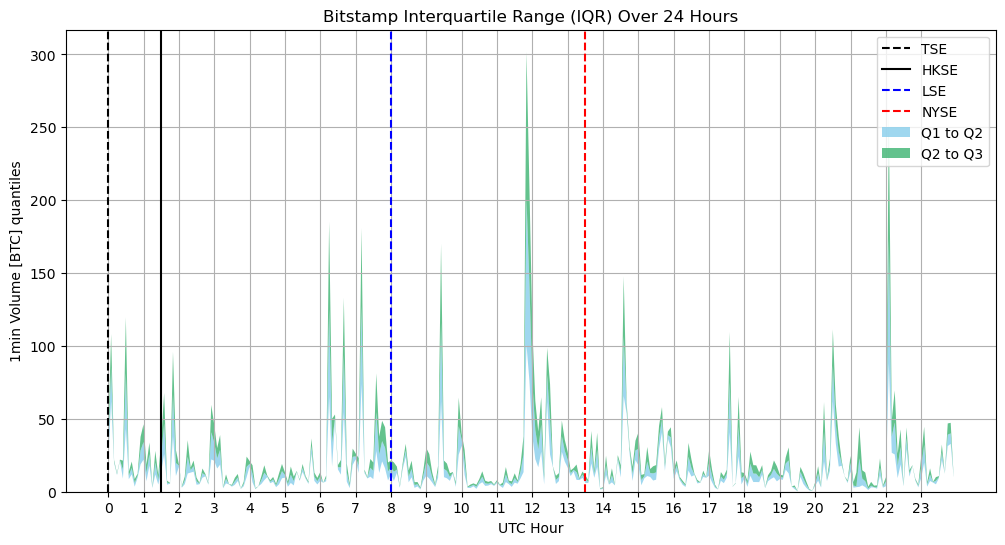

In [11]:
# Calculate IQR ranges


# Plot
fig, ax = plt.subplots(figsize=(12, 6))

minutes = [0, 90, 480, 810]  # Convert times to minutes since midnight

colors = ['black', 'black', 'blue', 'red']
labels = ['TSE', 'HKSE', 'LSE', 'NYSE']
for t, color, label in zip(minutes, colors, labels):
    if label == 'HKSE':
        ax.axvline(x=t, color=color, label=label)
    else:   
        ax.axvline(x=t, linestyle='--', color=color, label=label)

ax.stackplot(trx_dataset_grouped_viz['minutes_since_midnight'], trx_dataset_grouped_viz['Q1'], trx_dataset_grouped_viz['Q1_Q2'], trx_dataset_grouped_viz['Q2_Q3'], 
             labels=["", "Q1 to Q2", "Q2 to Q3"], colors=['none','skyblue', 'mediumseagreen'], edgecolor='none', alpha=0.8)

# Formatting X-axis to show only hours
ax.set_xticks(np.arange(0, 1381, 60))  # Tick every 60 minutes (every hour)
ax.set_xticklabels(range(0, 24))  # Labels from 0 to 23 (only hours)

# Labels and title
ax.set_xlabel("UTC Hour")
ax.set_ylabel("1min Volume [BTC] quantiles")
ax.set_title("Bitstamp Interquartile Range (IQR) Over 24 Hours")
ax.legend()
ax.grid(True)

plt.show()

### Distribution plot

In [12]:
print(f"minimal volume after 0 is {trx_dataset_grouped.loc[trx_dataset_grouped['deseasoned_total_volume'] >0]['deseasoned_total_volume'].min()} BTC")
print("!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7")

minimal volume after 0 is 0.03257722499999982 BTC
!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7


In [17]:
trx_dataset_grouped['log_deseasoned_total_volume'] = np.log(trx_dataset_grouped['deseasoned_total_volume'] + 1e-7)

c:\Users\peter\anaconda3\envs\IML2024\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
trx_dataset_grouped['log_deseasoned_total_volume']
#dropna
trx_dataset_grouped = trx_dataset_grouped.dropna()
trx_dataset_grouped["deseasoned_total_volume"].isna().sum()

In [25]:
trx_dataset_grouped


,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume,time,log_deseasoned_total_volume
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7543.32,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,4.336679,21:00:00,1.467109
1,1527800700,2018-05-31 21:05:00+00:00,7543.32,7551.68,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,6.236082,21:05:00,1.830352
2,1527801000,2018-05-31 21:10:00+00:00,7550.00,7536.08,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,28.051193,21:10:00,3.334031
3,1527801300,2018-05-31 21:15:00+00:00,7540.84,7541.98,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,27.529115,21:15:00,3.315244
4,1527801600,2018-05-31 21:20:00+00:00,7542.88,7556.74,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,9.684735,21:20:00,2.270551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1530480300,2018-07-01 21:25:00+00:00,6343.01,6344.78,6352.33,6341.94,3.603874,7.441438,11.045312,-3.837564,27.0,15.0,12.0,1.880049,21:25:00,0.631298
594,1530480600,2018-07-01 21:30:00+00:00,6341.90,6341.81,6348.84,6341.80,1.135858,3.644656,4.780514,-2.508798,23.0,21.0,2.0,2.244712,21:30:00,0.808577
595,1530480900,2018-07-01 21:35:00+00:00,6346.00,6364.36,6366.34,6344.10,7.818256,3.642919,11.461175,4.175337,37.0,13.0,24.0,5.857047,21:35:00,1.767646
598,1530481800,2018-07-01 21:50:00+00:00,6356.07,6362.78,6377.05,6353.21,14.494955,4.153105,18.648061,10.341850,30.0,14.0,16.0,1.260102,21:50:00,0.231193


DataFrame shape: (296, 16)
Columns: Index(['timestamp_id', 'datetime', 'first_price', 'last_price', 'max_price',
       'min_price', 'buy_volume', 'sell_volume', 'total_volume',
       'volume_imbalance', 'buy_transactions', 'sell_transactions',
       'transaction_imbalance', 'deseasoned_total_volume', 'time',
       'log_deseasoned_total_volume'],
      dtype='object')
NaN count in log_deseasoned_total_volume: 0
Sample of log_deseasoned_total_volume:
0    1.467109
1    1.830352
2    3.334031
3    3.315244
4    2.270551
Name: log_deseasoned_total_volume, dtype: float64


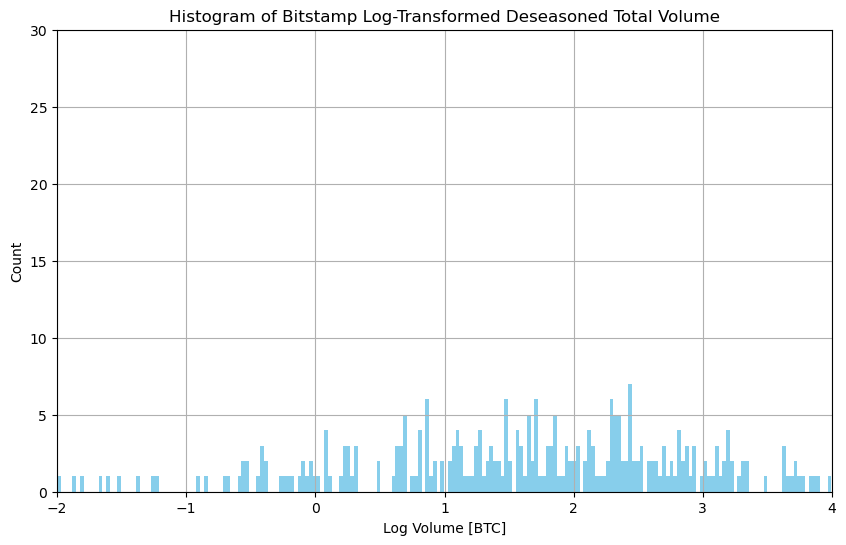

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Verify the DataFrame
print("DataFrame shape:", trx_dataset_grouped.shape)
print("Columns:", trx_dataset_grouped.columns)
print("NaN count in log_deseasoned_total_volume:", trx_dataset_grouped['log_deseasoned_total_volume'].isnull().sum())
print("Sample of log_deseasoned_total_volume:")
print(trx_dataset_grouped['log_deseasoned_total_volume'].head())

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(trx_dataset_grouped['log_deseasoned_total_volume'], bins=300, color='skyblue', edgecolor='none')
plt.xlim(-2, 4)  # Adjusted based on data range (-0.4 to 3.3)
plt.ylim(0, 30)  # Adjusted based on expected frequency with 296 rows
plt.title("Histogram of Bitstamp Log-Transformed Deseasoned Total Volume")
plt.xlabel("Log Volume [BTC]")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [29]:
# Calculate mean, variance, skewness, and kurtosis of the 'volume' column
mean_volume = trx_dataset_grouped['log_deseasoned_total_volume'].mean()
variance_volume = trx_dataset_grouped['log_deseasoned_total_volume'].var()
skewness_volume = stats.skew(trx_dataset_grouped['log_deseasoned_total_volume'])
kurtosis_volume = stats.kurtosis(trx_dataset_grouped['log_deseasoned_total_volume'])

# Display the results
print(f"Mean: {mean_volume}")
print(f"Variance: {variance_volume}")
print(f"Skewness: {skewness_volume}")
print(f"Kurtosis: {kurtosis_volume}")

Mean: 1.6632216144951548
Variance: 2.0566266877828667
Skewness: -0.3791386739612373
Kurtosis: 0.4721529632110806


In [30]:
trx_dataset_grouped.head()

,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume,time,log_deseasoned_total_volume
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7543.32,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,4.336679,21:00:00,1.467109
1,1527800700,2018-05-31 21:05:00+00:00,7543.32,7551.68,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,6.236082,21:05:00,1.830352
2,1527801000,2018-05-31 21:10:00+00:00,7550.00,7536.08,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,28.051193,21:10:00,3.334031
3,1527801300,2018-05-31 21:15:00+00:00,7540.84,7541.98,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,27.529115,21:15:00,3.315244
4,1527801600,2018-05-31 21:20:00+00:00,7542.88,7556.74,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,9.684735,21:20:00,2.270551


### ACF and PACF

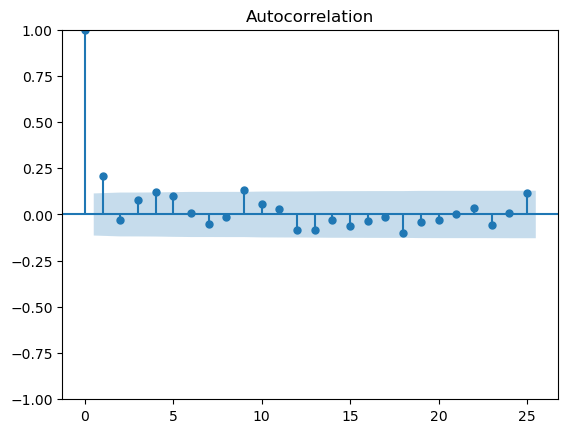

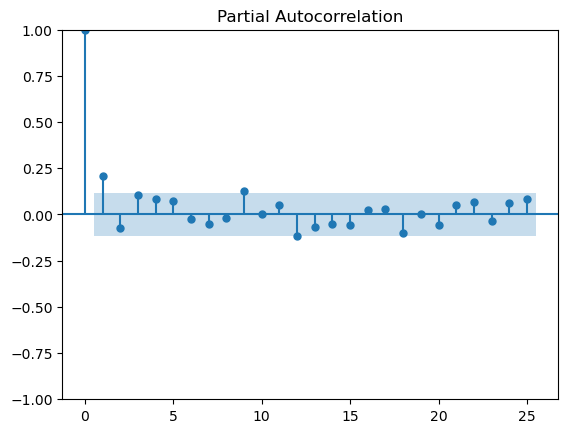

In [31]:
plot_acf(trx_dataset_grouped['log_deseasoned_total_volume']);
plot_pacf(trx_dataset_grouped['log_deseasoned_total_volume']);

### LOB data

#### Example of loading

In [150]:
lob_df = create_lob_dataset(use_load=False)
lob_df.head()

preprocessed lob Data loaded successfully.


,datetime,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
0,2018-06-04 22:00:02+00:00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
1,2018-06-04 22:00:34+00:00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642,6.19,583654.707923,1759.120109,2643.822035,2541.158836
2,2018-06-04 22:01:01+00:00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
3,2018-06-04 22:01:33+00:00,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480,4.96,583650.421009,1719.984195,2609.173283,2497.558029
4,2018-06-04 22:02:02+00:00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462


## Playground for future (Irrelevant), You can ignore what's below

In [16]:
single_file_ob_dataset = ["./data/bitstamp_ob_04_07_2018.zip"]
lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
lob_dataset

DatasetDict({
    train: Dataset({
        features: ['time', 'type', 'price', 'amount '],
        num_rows: 24084011
    })
})

In [ ]:
lob_dataset = lob_dataset['train'].to_pandas()
lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
lob_dataset.drop(['time'], axis=1, inplace = True)
lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)
lob_dataset.head()


,type,price,amount,datetime
0,b,6613.32,0.068823,2018-07-03 22:00:01+00:00
1,b,6613.31,3.709311,2018-07-03 22:00:01+00:00
2,b,6608.79,0.015000,2018-07-03 22:00:01+00:00
3,b,6608.78,1.000000,2018-07-03 22:00:01+00:00
4,b,6608.77,1.911835,2018-07-03 22:00:01+00:00


### Playground for future LOB feature creation

In [50]:
# Define data
lb_df = {
    'type': ['b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a']*2,
    'price': [100, 101, 102, 103, 104, 105, 107, 108, 109, 110]*2,
    'amount': [10, 5, 8, 10, 17, 15, 12, 8, 12, 33]*2,
    'datetime': pd.to_datetime(['2024-03-04 22:31:01'] * 10 + ['2024-03-04 22:32:01'] * 10)  # Convert to datetime
}

# Create DataFrame
lb_df = pd.DataFrame(lb_df)
lb_df

,type,price,amount,datetime
0,b,100,10,2024-03-04 22:31:01
1,b,101,5,2024-03-04 22:31:01
2,b,102,8,2024-03-04 22:31:01
3,b,103,10,2024-03-04 22:31:01
4,b,104,17,2024-03-04 22:31:01
5,a,105,15,2024-03-04 22:31:01
6,a,107,12,2024-03-04 22:31:01
7,a,108,8,2024-03-04 22:31:01
8,a,109,12,2024-03-04 22:31:01
9,a,110,33,2024-03-04 22:31:01


In [59]:
import pandas as pd
import numpy as np

def compute_features(group, thresholds):
    bids = group[group['type'] == 'b'].sort_values(by='price', ascending=False)  # Highest bid first
    asks = group[group['type'] == 'a'].sort_values(by='price', ascending=True)   # Lowest ask first
    
    if bids.empty or asks.empty:
        return pd.Series({
            'Best Ask': np.nan, 'Best Bid': np.nan, 'ask_volume': np.nan, 'bid_volume': np.nan,
            **{f'ask_slope_{x}': np.nan for x in thresholds},
            **{f'bid_slope_{x}': np.nan for x in thresholds}
        })
    
    best_bid = bids['price'].iloc[0]
    best_ask = asks['price'].iloc[0]
    total_bid_volume = bids['amount'].sum()
    total_ask_volume = asks['amount'].sum()
    
    def find_offset_price(df, total_volume, x, side='bid'):
        """Find price level where cumulative volume reaches x% of total volume."""
        cum_vol = df['amount'].cumsum()
        threshold_volume = total_volume * (x / 100)
        idx = (cum_vol >= threshold_volume).idxmax()
        return df.loc[idx, 'price']
    
    ask_slopes = {}
    bid_slopes = {}
    
    for x in thresholds:
        # Compute p_b_x and delta_x_b
        p_b_x = find_offset_price(bids, total_bid_volume, x, 'bid')
        delta_x_b = best_bid - p_b_x
        p_a_delta_x_b = best_ask + delta_x_b
        ask_slopes[f'ask_slope_{x}'] = asks[asks['price'] <= p_a_delta_x_b]['amount'].sum()
        
        # Compute p_a_x and delta_x_a
        p_a_x = find_offset_price(asks, total_ask_volume, x, 'ask')
        delta_x_a = best_ask - p_a_x
        p_b_delta_x_a = best_bid + delta_x_a
        bid_slopes[f'bid_slope_{x}'] = bids[bids['price'] >= p_b_delta_x_a]['amount'].sum()
    
    return pd.Series({
        'Best Ask': best_ask, 'Best Bid': best_bid, 'ask_volume': total_ask_volume, 'bid_volume': total_bid_volume,
        **ask_slopes, **bid_slopes
    })

# Define percentage thresholds
thresholds = [1, 5, 10]
thresholds = [50]

# Group by datetime and compute features
result = lb_df.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
result


,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_50,bid_slope_50
0,2024-03-04 22:31:01,105,104,80,50,15,50
1,2024-03-04 22:32:01,105,104,80,50,15,50


In [62]:
thresholds = [1, 5, 10]
lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()

In [61]:
lob_dataset_grouped.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
0,2018-07-03 22:00:01+00:00,6614.99,6613.32,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958
1,2018-07-03 22:00:34+00:00,6614.99,6613.32,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659
2,2018-07-03 22:01:01+00:00,6614.99,6613.32,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981
3,2018-07-03 22:01:34+00:00,6614.98,6608.82,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405
4,2018-07-03 22:02:01+00:00,6614.25,6608.80,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057


In [63]:
lob_dataset_grouped['spread'] = lob_dataset_grouped['Best Ask'] - lob_dataset_grouped['Best Bid']
lob_dataset_grouped['lob_volume_imbalance'] = np.abs(lob_dataset_grouped['bid_volume'] - lob_dataset_grouped['ask_volume'])
for thresh in thresholds:
    lob_dataset_grouped[f'slope_imbalance_{thresh}'] = np.abs(lob_dataset_grouped[f'ask_slope_{thresh}'] - lob_dataset_grouped[f'bid_slope_{thresh}'])
lob_dataset_grouped.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
lob_dataset_grouped.head()

,datetime,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
0,2018-07-03 22:00:01+00:00,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958,1.67,564622.017881,1316.658453,2361.418174,2253.718089
1,2018-07-03 22:00:34+00:00,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659,1.67,564625.100992,1327.736507,2381.933732,2279.472153
2,2018-07-03 22:01:01+00:00,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981,1.67,564632.391192,1322.070746,2364.737358,2273.149822
3,2018-07-03 22:01:34+00:00,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405,6.16,564631.709120,1325.153249,2384.027946,2271.871729
4,2018-07-03 22:02:01+00:00,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057,5.45,564622.856458,1323.975978,2372.342136,2268.130806


In [ ]:
# !!!!!!!!!!!! ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!
# It executes for more than 3 hours
# Creating LOB features

# df_full_lob = pd.DataFrame()
# thresholds = [1, 5, 10]

# for file in tqdm(lob_zip_files):
#     single_file_ob_dataset = [file]
#     lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

#     lob_dataset = lob_dataset['train'].to_pandas()
#     lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
#     lob_dataset.drop(['time'], axis=1, inplace = True)
#     lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)

#     lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
#     df_full_lob = pd.concat([df_full_lob, lob_dataset_grouped], ignore_index=True)

  1%|          | 1/109 [00:19<35:33, 19.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  2%|▏         | 2/109 [01:06<1:03:29, 35.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  3%|▎         | 3/109 [01:56<1:14:53, 42.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  4%|▎         | 4/109 [02:45<1:18:10, 44.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  5%|▍         | 5/109 [04:14<1:45:31, 60.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▌         | 6/109 [05:47<2:03:00, 71.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▋         | 7/109 [07:22<2:15:01, 79.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  7%|▋         | 8/109 [08:53<2:19:48, 83.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  8%|▊         | 9/109 [10:21<2:20:48, 84.49s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  9%|▉         | 10/109 [11:48<2:21:06, 85.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 10%|█         | 11/109 [13:15<2:20:01, 85.73s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 11%|█         | 12/109 [14:43<2:19:57, 86.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 12%|█▏        | 13/109 [16:11<2:19:20, 87.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 13%|█▎        | 14/109 [17:42<2:19:46, 88.28s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 14%|█▍        | 15/109 [19:10<2:17:58, 88.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 15%|█▍        | 16/109 [20:37<2:16:07, 87.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 16%|█▌        | 17/109 [22:05<2:14:37, 87.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 18/109 [23:31<2:12:17, 87.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 19/109 [24:57<2:10:18, 86.87s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 18%|█▊        | 20/109 [26:48<2:19:25, 94.00s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 19%|█▉        | 21/109 [29:32<2:48:58, 115.21s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 20%|██        | 22/109 [31:44<2:54:19, 120.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 21%|██        | 23/109 [33:56<2:57:13, 123.64s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 22%|██▏       | 24/109 [36:08<2:58:45, 126.19s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 23%|██▎       | 25/109 [38:22<2:59:47, 128.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 24%|██▍       | 26/109 [40:42<3:02:26, 131.89s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 25%|██▍       | 27/109 [42:51<2:59:18, 131.20s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 26%|██▌       | 28/109 [44:57<2:54:57, 129.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 27%|██▋       | 29/109 [46:54<2:47:48, 125.86s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 30/109 [48:23<2:31:00, 114.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 31/109 [50:27<2:32:37, 117.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 29%|██▉       | 32/109 [52:42<2:37:37, 122.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 30%|███       | 33/109 [54:56<2:39:42, 126.09s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 31%|███       | 34/109 [57:10<2:40:49, 128.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 32%|███▏      | 35/109 [59:44<2:47:51, 136.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 33%|███▎      | 36/109 [1:01:54<2:43:34, 134.45s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 34%|███▍      | 37/109 [1:04:11<2:42:04, 135.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 35%|███▍      | 38/109 [1:06:26<2:39:54, 135.13s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 36%|███▌      | 39/109 [1:08:40<2:37:13, 134.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 37%|███▋      | 40/109 [1:10:52<2:33:57, 133.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 38%|███▊      | 41/109 [1:13:06<2:31:46, 133.93s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▊      | 42/109 [1:15:17<2:28:36, 133.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▉      | 43/109 [1:17:36<2:28:24, 134.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 40%|████      | 44/109 [1:19:48<2:25:03, 133.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 41%|████▏     | 45/109 [1:21:26<2:11:33, 123.33s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 42%|████▏     | 46/109 [1:23:38<2:12:14, 125.94s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 43%|████▎     | 47/109 [1:25:58<2:14:22, 130.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 44%|████▍     | 48/109 [1:28:14<2:13:59, 131.80s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 45%|████▍     | 49/109 [1:29:44<1:59:15, 119.26s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 46%|████▌     | 50/109 [1:31:57<2:01:18, 123.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 47%|████▋     | 51/109 [1:34:17<2:03:57, 128.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 48%|████▊     | 52/109 [1:36:29<2:02:55, 129.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 49%|████▊     | 53/109 [1:38:22<1:56:20, 124.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|████▉     | 54/109 [1:39:54<1:45:05, 114.65s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|█████     | 55/109 [1:41:24<1:36:41, 107.44s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 51%|█████▏    | 56/109 [1:42:50<1:29:14, 101.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 52%|█████▏    | 57/109 [1:44:30<1:27:09, 100.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 53%|█████▎    | 58/109 [1:45:57<1:22:10, 96.68s/it] 

Generating train split: 0 examples [00:00, ? examples/s]

 54%|█████▍    | 59/109 [1:47:25<1:18:24, 94.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 55%|█████▌    | 60/109 [1:48:54<1:15:31, 92.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 56%|█████▌    | 61/109 [1:50:30<1:14:53, 93.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 57%|█████▋    | 62/109 [1:52:01<1:12:38, 92.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 58%|█████▊    | 63/109 [1:53:31<1:10:31, 91.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 59%|█████▊    | 64/109 [1:55:01<1:08:34, 91.43s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 60%|█████▉    | 65/109 [1:56:37<1:08:01, 92.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████    | 66/109 [1:58:08<1:05:58, 92.05s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████▏   | 67/109 [1:59:34<1:03:19, 90.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 62%|██████▏   | 68/109 [2:01:07<1:02:09, 90.96s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 63%|██████▎   | 69/109 [2:02:42<1:01:32, 92.31s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 64%|██████▍   | 70/109 [2:03:37<52:47, 81.22s/it]  

Generating train split: 0 examples [00:00, ? examples/s]

 65%|██████▌   | 71/109 [2:05:07<53:03, 83.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 66%|██████▌   | 72/109 [2:06:33<52:02, 84.40s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 67%|██████▋   | 73/109 [2:08:07<52:26, 87.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 68%|██████▊   | 74/109 [2:09:37<51:27, 88.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 69%|██████▉   | 75/109 [2:11:07<50:15, 88.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 70%|██████▉   | 76/109 [2:12:29<47:40, 86.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 71%|███████   | 77/109 [2:14:04<47:32, 89.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 78/109 [2:15:33<45:59, 89.02s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 79/109 [2:17:04<44:49, 89.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 73%|███████▎  | 80/109 [2:18:29<42:42, 88.37s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 74%|███████▍  | 81/109 [2:20:08<42:44, 91.58s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 75%|███████▌  | 82/109 [2:21:41<41:19, 91.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 76%|███████▌  | 83/109 [2:23:10<39:27, 91.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 77%|███████▋  | 84/109 [2:24:36<37:20, 89.63s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 78%|███████▊  | 85/109 [2:25:46<33:24, 83.53s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 79%|███████▉  | 86/109 [2:26:33<27:49, 72.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 80%|███████▉  | 87/109 [2:27:22<24:04, 65.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 81%|████████  | 88/109 [2:28:10<21:03, 60.17s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 82%|████████▏ | 89/109 [2:29:03<19:21, 58.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 90/109 [2:29:53<17:39, 55.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 91/109 [2:30:42<16:07, 53.78s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 84%|████████▍ | 92/109 [2:31:29<14:35, 51.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 85%|████████▌ | 93/109 [2:32:21<13:48, 51.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 86%|████████▌ | 94/109 [2:33:08<12:35, 50.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 87%|████████▋ | 95/109 [2:33:58<11:41, 50.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 88%|████████▊ | 96/109 [2:34:43<10:34, 48.82s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 89%|████████▉ | 97/109 [2:35:37<10:04, 50.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 90%|████████▉ | 98/109 [2:36:26<09:09, 49.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 91%|█████████ | 99/109 [2:37:14<08:13, 49.32s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 92%|█████████▏| 100/109 [2:38:18<08:03, 53.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 93%|█████████▎| 101/109 [2:39:58<09:00, 67.51s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▎| 102/109 [2:41:35<08:54, 76.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▍| 103/109 [2:43:05<08:03, 80.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 95%|█████████▌| 104/109 [2:44:32<06:51, 82.38s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 96%|█████████▋| 105/109 [2:46:15<05:55, 88.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 97%|█████████▋| 106/109 [2:47:51<04:32, 90.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 98%|█████████▊| 107/109 [2:49:22<03:01, 90.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 99%|█████████▉| 108/109 [2:51:03<01:33, 93.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

100%|██████████| 109/109 [2:52:41<00:00, 95.06s/it]


In [ ]:
# df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750


In [ ]:
# df_full_lob.sort_values('datetime', inplace=True)
# df_full_lob.reset_index(drop=True, inplace=True)

In [ ]:
# df_full_lob['spread'] = df_full_lob['Best Ask'] - df_full_lob['Best Bid']
# df_full_lob['lob_volume_imbalance'] = np.abs(df_full_lob['bid_volume'] - df_full_lob['ask_volume'])
# thresholds = [1, 5, 10]
# for thresh in thresholds:
#     df_full_lob[f'slope_imbalance_{thresh}'] = np.abs(df_full_lob[f'ask_slope_{thresh}'] - df_full_lob[f'bid_slope_{thresh}'])
# # df_full_lob.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
# df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642,6.19,583654.707923,1759.120109,2643.822035,2541.158836
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480,4.96,583650.421009,1719.984195,2609.173283,2497.558029
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462


In [ ]:
# df_full_lob.drop(['Best Ask', 'Best Bid'], axis=1).to_parquet("data/df_full_lob.parquet")